# Summary

----

# Imports

In [4]:
%run _imports.ipynb

Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2017-12-20 20:11:59.659432


In [5]:
NOTEBOOK_NAME = 'project_report'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Parameters

In [6]:
ARCHIVE_HDF5_DIR = Path('archive_to_hdf5/pmc_archives_1/').absolute()
ARCHIVE_HDF5_DIR

PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1')

In [7]:
hdf5_archives = list(ARCHIVE_HDF5_DIR.glob('*.h5'))
hdf5_archives[:3]

[PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/0b.h5'),
 PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/f5.h5'),
 PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/11.h5')]

# Run jobs

## Job parameters

In [308]:
JOB_ID = 'job_1'
DATA_ID = 'table_statistics_1'

In [309]:
JOB_DIR = f"~/datapkg/{os.environ['DB_SCHEMA']}/notebooks/{NOTEBOOK_NAME}/{JOB_ID}"
DATA_DIR = f"~/datapkg/{os.environ['DB_SCHEMA']}/notebooks/{NOTEBOOK_NAME}/{DATA_ID}"

os.makedirs(op.expanduser(JOB_DIR), exist_ok=True)
os.makedirs(op.expanduser(DATA_DIR), exist_ok=True)
print(JOB_DIR, DATA_DIR, sep='\n')

~/datapkg/pmc-tables/notebooks/project_report/job_1
~/datapkg/pmc-tables/notebooks/project_report/table_statistics_1


In [310]:
ENV = {
    'PATH': '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/usr/bin:/bin',
    'OMP_NUM_THREADS': '1',
    'OPENMM_CPU_THREADS': '1',
}

## Script file

In [336]:
%%file {DATA_DIR}.py
import time
import os.path as op
import json
import pickle
import warnings
import logging
from pathlib import Path

import tables
import pandas as pd

import pmc_tables

warnings.filterwarnings("ignore", category=tables.NaturalNameWarning)
logger = logging.getLogger(__name__)


def count_tables_per_node(pmc_node, store):
    pmc_table_stats = []
    for file_node in pmc_node._f_iter_nodes():
        for table_node in file_node._f_iter_nodes():
#             logger.error(f"Processing table node {table_node}")
            try:
                child = table_node._f_get_child('table')
            except tables.NoSuchNodeError:
                logger.error(f"No such node: {table_node._v_name}/table")
                continue

            try:
                df = pd.read_hdf(store, key=table_node._v_pathname)
                pmc_table_stats.append((table_node._v_pathname, ) + df.shape)
            except Exception as e:
                logger.error(f"Exception occured when processing table node: {type(e)}: {e}")
                pass
    return pmc_table_stats    


def count_tables_per_file(hdf5_file):
    table_stats = []
    with pd.HDFStore(hdf5_file, 'r') as store:
        for pmc_node in store.root._f_iter_nodes():

            try:
                node_name = pmc_node._v_name
            except Exception as e:
                logger.error(f"Exception occured when processing file `{hdf5_file}`: {type(e)}: {e}")
                continue

            try:
                pmc_table_stats = count_tables_per_node(pmc_node, store)
            except Exception as e:
                logger.error(f"Exception occured when processing file `{hdf5_file}`: {type(e)}: {e}")
                table_stats += (node_name, ) + (None, ) * 3 + (str(type(e)), str(e))
                continue
            else:
                if pmc_table_stats:
                    for pcm_table_stat in pmc_table_stats:
                        table_stats.append((node_name, ) + pcm_table_stat + (None, None))
                else:
                    table_stats.append((node_name, ) + (None, ) * 5)
    
    return table_stats


def worker(hdf5_file, output_dir):
    output_file = output_dir.joinpath(hdf5_file.stem).with_suffix('.csv')
    if output_file.is_file():
        return {'output_file': output_file.as_posix()}

    table_stats = count_tables_per_file(hdf5_file)

    columns = ['pmc_id', 'table_name', 'num_rows', 'num_columns', 'error_type', 'error_message']
    table_stats_df = pd.DataFrame(table_stats, columns=columns)
    table_stats_df.to_csv(output_file, index=False)


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input-file')
    parser.add_argument('-o', '--output-dir')
    args = parser.parse_args()

    logging.basicConfig(format='[%(name)s] %(message)s', level=logging.DEBUG)

    hdf5_file = Path(args.input_file).absolute()
    output_dir = Path(args.output_dir).absolute()

    results = worker(hdf5_file, output_dir)

Overwriting /home/kimlab1/strokach/datapkg/pmc-tables/notebooks/project_report/table_statistics_1.py


## System commands

In [359]:
hdf5_files = list(ARCHIVE_HDF5_DIR.glob('*.h5'))
hdf5_files[:3]

[PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/0b.h5'),
 PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/f5.h5'),
 PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/11.h5')]

In [360]:
assert len(hdf5_files) == 256

In [361]:
system_commands = []

for input_file in ARCHIVE_HDF5_DIR.glob('*.h5'):
    if input_file.parts[1] != 'home':
        input_file = Path('/home').joinpath(*input_file.parts[1:])
    output_dir = Path(DATA_DIR).expanduser()
    if output_dir.parts[1] != 'home':
        output_dir = Path('/home').joinpath(*output_dir.parts[1:])
    system_command = f'python "../{DATA_ID}.py" -i "{input_file}" -o "{output_dir}"'
    system_commands.append(system_command)
    
system_commands = pd.DataFrame(system_commands, columns=['system_command'])

In [362]:
len(system_commands)

256

In [363]:
!(cd {DATA_DIR}; echo {system_commands.iat[0, 0]})

python ../table_statistics_1.py -i /home/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1/0b.h5 -o /home/kimlab1/strokach/datapkg/pmc-tables/notebooks/project_report/table_statistics_1


In [364]:
# !(cd {DATA_DIR}; {system_commands.iat[0, 0]})

## Submit

In [365]:
import jobsubmitter

importlib.reload(jobsubmitter)

<module 'jobsubmitter' from '/home/kimlab1/strokach/working/jobsubmitter/jobsubmitter/__init__.py'>

In [366]:
js = jobsubmitter.JobSubmitter('beagle', JOB_DIR, DATA_DIR, ENV)
js

In [367]:
jo = jobsubmitter.JobOpts(JOB_ID, nproc=1, queue='medium', walltime='24:00:00', mem='6G')
jo

JobOpts(job_name='job_1', queue='medium', nproc=1, walltime='24:00:00', mem='6G', pmem=None, vmem=None, pvmem=None, email='noname@example.com', email_opts='a', qsub_shell='/bin/bash', qsub_script_args=None)

In [368]:
logging.getLogger().setLevel(logging.INFO)

In [369]:
len(system_commands)

256

In [370]:
# futures = js.submit(system_commands, jo, deplay=0.02)

**Results:**

In [403]:
results = js.job_status(system_commands)

HBox(children=(IntProgress(value=0, max=256), HTML(value='')))

In [404]:
done = results[results['status'] == 'done']
print(len(done))

256


In [405]:
failed = results[(results['status'] != 'done')]
print(len(failed))

0


**Do this in a loop until done...**

In [409]:
# futures = js.submit(remaining, jo, deplay=0.02)

In [410]:
results2 = js.job_status(system_commands)

HBox(children=(IntProgress(value=0, max=256), HTML(value='')))

In [411]:
failed = results2[results2['status'] != 'done']
print(len(failed))

0


### Collect results

In [412]:
result_files = list(Path(DATA_DIR).expanduser().glob('*.csv'))
print(result_files[:3])
assert len(result_files) == len(hdf5_files), (len(result_files), len(hdf5_files))

[PosixPath('/home/kimlab1/strokach/datapkg/pmc-tables/notebooks/project_report/table_statistics_1/48.csv'), PosixPath('/home/kimlab1/strokach/datapkg/pmc-tables/notebooks/project_report/table_statistics_1/f0.csv'), PosixPath('/home/kimlab1/strokach/datapkg/pmc-tables/notebooks/project_report/table_statistics_1/6f.csv')]


In [413]:
table_stats = []

for result_file in result_files:
    df = pd.read_csv(result_file)
    table_stats.append(df)
    
table_stats_df = pd.concat(table_stats, ignore_index=True)

In [456]:
table_stats_df.dropna(subset=['table_name']).to_csv(f'{NOTEBOOK_NAME}/table_stats.csv', index=False)

In [414]:
display(table_stats_df.head())
print(len(table_stats_df))

,pmc_id,table_name,num_rows,num_columns,error_type,error_message
0,PMC1033694,NaN,NaN,NaN,NaN,NaN
1,PMC1034939,NaN,NaN,NaN,NaN,NaN
2,PMC1035877,NaN,NaN,NaN,NaN,NaN
3,PMC1035885,NaN,NaN,NaN,NaN,NaN
4,PMC1035934,NaN,NaN,NaN,NaN,NaN


3926259


In [417]:
def get_table_parser(table_name):
    if pd.isnull(table_name):
        return None
    file_name = table_name.split('/')[-2]
    if file_name.endswith('.nxml') or file_name.endswith('.xml'):
        return 'xml'
    elif file_name.endswith('.xls') or file_name.endswith('.xlsx'):
        return 'excel'
    elif (file_name.endswith('.csv') or file_name.endswith('.csv.gz') or 
          file_name.endswith('.tsv') or file_name.endswith('.tsv.gz')):
        return 'text'
    else:
        raise Exception(f"Unknown file {table_name}.")

In [418]:
table_stats_df['table_parser'] = table_stats_df['table_name'].apply(get_table_parser)

In [421]:
Counter(table_stats_df['table_parser'])

Counter({None: 1535628, 'xml': 2383704, 'text': 6927})

In [422]:
table_stats_df.head()

,pmc_id,table_name,num_rows,num_columns,error_type,error_message,table_parser
0,PMC1033694,NaN,NaN,NaN,NaN,NaN,None
1,PMC1034939,NaN,NaN,NaN,NaN,NaN,None
2,PMC1035877,NaN,NaN,NaN,NaN,NaN,None
3,PMC1035885,NaN,NaN,NaN,NaN,NaN,None
4,PMC1035934,NaN,NaN,NaN,NaN,NaN,None


In [424]:
2383704 / (1535628 + 2383704)

0.6081913958807266

### Make plots

In [ ]:
fg, axes = plt.sub

In [457]:
df.head()

,pmc_id,table_name,num_rows,num_columns,error_type,error_message,table_parser
3178,PMC3103576,/PMC3103576/pone.0020488.s002.csv/sheet_0,42.0,11.0,NaN,NaN,text
3179,PMC3103576,/PMC3103576/pone.0020488.s003.csv/sheet_0,35.0,11.0,NaN,NaN,text
5579,PMC3599933,/PMC3599933/1471-2288-13-1-S2.csv/sheet_0,51130.0,16.0,NaN,NaN,text
5644,PMC3617018,/PMC3617018/pcbi.1003017.s013.csv/sheet_0,16820.0,43.0,NaN,NaN,text
6455,PMC3799824,/PMC3799824/pone.0076539.s008.csv/sheet_0,2470.0,2.0,NaN,NaN,text


In [461]:
len(set(table_stats_df['pmc_id']))

2396216

In [462]:
len(set(table_stats_df[table_stats_df['table_name'].notnull()]['pmc_id']))

860589

In [463]:
860589 / 2396216

0.35914500195307936

In [551]:
64 + 36

100

In [518]:
table_stats_matches = pd.read_csv('query_mutation_tables/table_stats_matches.csv')

In [458]:
grps = table_stats_df.groupby('pmc_id')['table_name'].count()

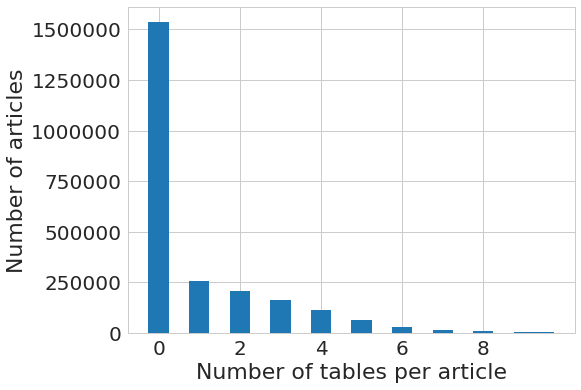

In [546]:
fg, axes = plt.subplots(figsize=(8, 6))

plt.hist(grps.values, range=(0, 10), bins=20)
plt.xticks([0.25 + x for x in range(0, 10, 2)], range(0, 10, 2))

plt.xlabel("Number of tables per article")
plt.ylabel("Number of articles")

plt.savefig(f'{NOTEBOOK_NAME}/tables_per_article.pdf', bbox_index='tight')
plt.savefig(f'{NOTEBOOK_NAME}/tables_per_article.png', dpi=300, bbox_index='tight')

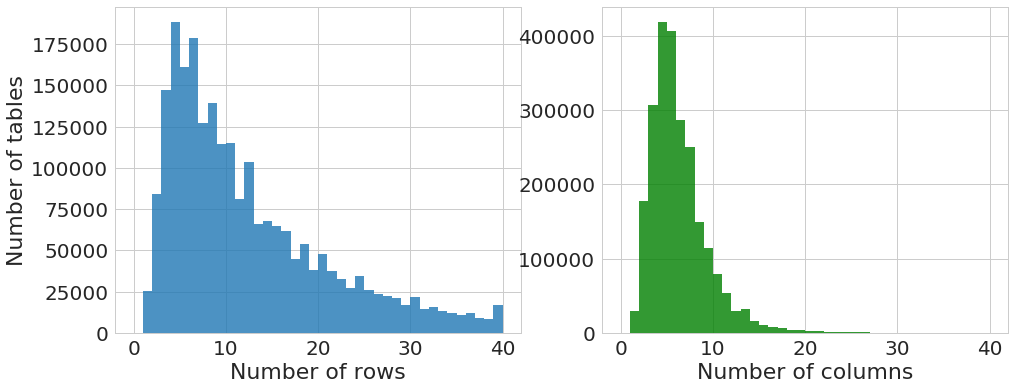

In [547]:
fg, axs = plt.subplots(1, 2, figsize=(16, 6))

df = table_stats_df[['num_rows', 'num_columns']].dropna()

plt.axes(axs[0])
plt.hist(df['num_rows'], range=(0, 40), bins=40, alpha=0.8)
plt.xlabel("Number of rows")
plt.ylabel("Number of tables")

plt.axes(axs[1])
plt.hist(df['num_columns'], range=(0, 40), bins=40, alpha=0.8, facecolor='green')
plt.xlabel("Number of columns")

# plt.suptitle(f"All tables (n = {len(df):2,})", y=1)
# plt.tight_layout()

plt.savefig(f'{NOTEBOOK_NAME}/all_tables_stats.pdf', bbox_index='tight')
plt.savefig(f'{NOTEBOOK_NAME}/all_tables_stats.png', dpi=300, bbox_index='tight')

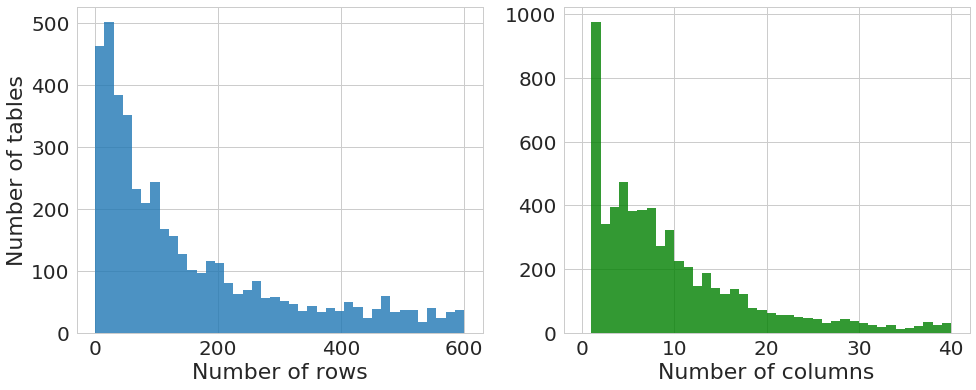

In [548]:
fg, axs = plt.subplots(1, 2, figsize=(16, 6))

df = table_stats_df[table_stats_df['table_parser'] == 'text'][['num_rows', 'num_columns']].dropna()

plt.axes(axs[0])
plt.hist(df['num_rows'], range=(0, 600), bins=40, alpha=0.8)
plt.xlabel("Number of rows")
plt.ylabel("Number of tables")

plt.axes(axs[1])
plt.hist(df['num_columns'], range=(0, 40), bins=40, alpha=0.8, facecolor='green')
plt.xlabel("Number of columns")

# plt.suptitle(f"Tables extracted from CSV files (n = {len(df):2,})", y=1)

plt.savefig(f'{NOTEBOOK_NAME}/csv_tables_stats.pdf', bbox_index='tight')
plt.savefig(f'{NOTEBOOK_NAME}/csv_tables_stats.png', dpi=300, bbox_index='tight')

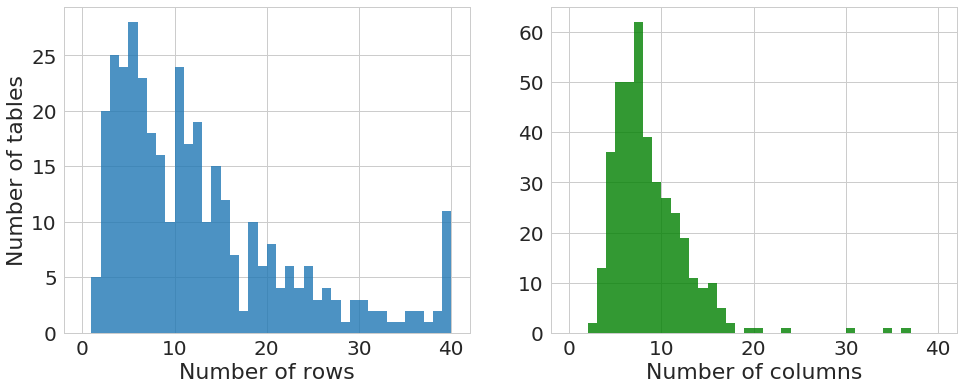

In [549]:
fg, axs = plt.subplots(1, 2, figsize=(16, 6))

df = table_stats_matches

plt.axes(axs[0])
plt.hist(df['num_rows'], range=(0, 40), bins=40, alpha=0.8)
plt.xlabel("Number of rows")
plt.ylabel("Number of tables")

plt.axes(axs[1])
plt.hist(df['num_columns'], range=(0, 40), bins=40, alpha=0.8, facecolor='green')
plt.xlabel("Number of columns")

# plt.suptitle(f"Tables describing gene mutations (n = {len(df):2,})", y=1)

plt.savefig(f'{NOTEBOOK_NAME}/mutation_table_stats.pdf', bbox_index='tight')
plt.savefig(f'{NOTEBOOK_NAME}/mutation_table_stats.png', dpi=300, bbox_index='tight')

Text(0.5,1,'All tables (n = 2,390,631)')

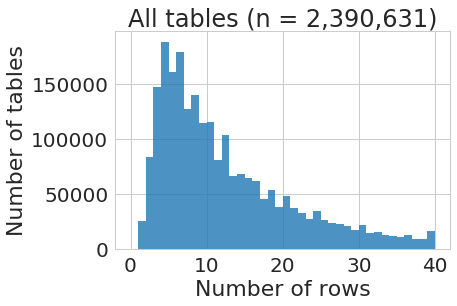

In [452]:
df = table_stats_df['num_rows'].dropna()

plt.hist(df, range=(0, 40), bins=40, alpha=0.8)

plt.xlabel("Number of rows")
plt.ylabel("Number of tables")
plt.title(f"All tables (n = {len(df):2,})")

Text(0.5,1,'Tables from CSV / TSV files (n = 6,927)')

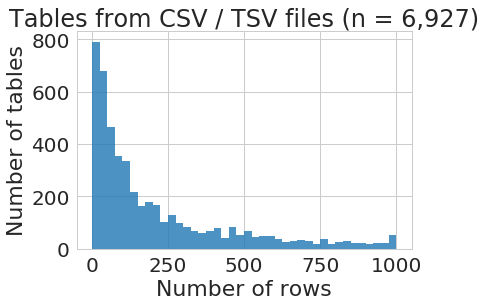

In [454]:
df = table_stats_df[table_stats_df['table_parser'] == 'text']

plt.hist(df['num_rows'].dropna(), range=(0, 1000), bins=40, alpha=0.8)

plt.xlabel("Number of rows")
plt.ylabel("Number of tables")
plt.title(f"Tables from CSV / TSV files (n = {len(df):2,})")

In [425]:
table_stats_df['num_rows'].max()

22512954.0

Text(0,0.5,'Number of tables')

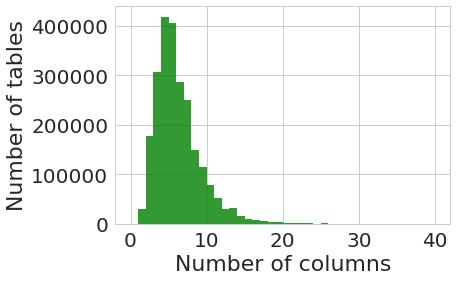

In [428]:
plt.hist(table_stats_df['num_columns'].dropna(), range=(0, 40), bins=40, alpha=0.8, facecolor='green')

plt.xlabel("Number of columns")
plt.ylabel("Number of tables")

Text(0,0.5,'Number of tables')

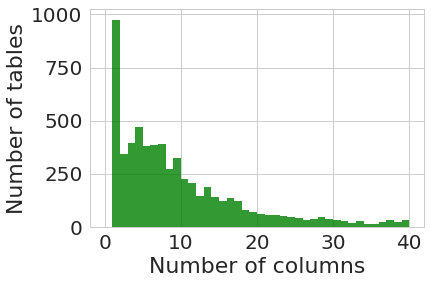

In [434]:
df = table_stats_df[table_stats_df['table_parser'] == 'text']

plt.hist(df['num_columns'].dropna(), range=(0, 40), bins=40, alpha=0.8, facecolor='green')

plt.xlabel("Number of columns")
plt.ylabel("Number of tables")

In [427]:
table_stats_df['num_columns'].max()

4701.0

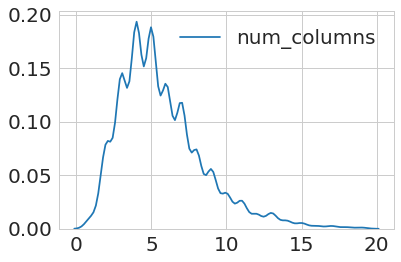

In [91]:
sns.kdeplot(table_stats_df['num_columns'].dropna(), clip=(0, 20))